In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-muted')
plt.rcParams['figure.figsize'] = (12, 6)

# Load data duy nhất 1 lần
DATA_PATH = "../../data/cleaned/Preprocessing_06.csv"
df = pd.read_csv(DATA_PATH)

# Ép kiểu Segment để đảm bảo thứ tự
segment_order = ['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP']
df['Segment'] = pd.Categorical(df['Segment'], categories=segment_order, ordered=True)

print(f"✅ Dataset Loaded: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()
df.info()

✅ Dataset Loaded: 19081 rows, 13 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19081 entries, 0 to 19080
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Price_Billion  19081 non-null  float64 
 1   Price_Per_m2   19081 non-null  float64 
 2   Area_m2        19081 non-null  float64 
 3   District       19081 non-null  object  
 4   Ward           19081 non-null  object  
 5   Bedrooms       19081 non-null  int64   
 6   Is_MatTien     19081 non-null  int64   
 7   Width_m        19081 non-null  float64 
 8   Floors         19081 non-null  float64 
 9   Is Hem         19081 non-null  int64   
 10  Post Time      19081 non-null  object  
 11  Toilets        19081 non-null  int64   
 12  Segment        19081 non-null  category
dtypes: category(1), float64(5), int64(4), object(3)
memory usage: 1.8+ MB


    Price_Billion   : Giá nhà (tỷ VNĐ)
    Price_Per_m2    : Giá trên mỗi mét vuông
    Area_m2         : Diện tích nhà
    District        : Quận
    Ward            : Phường
    Bedrooms        : Số phòng ngủ
    Toilets         : Số toilet
    Floors          : Số tầng
    Width_m         : Chiều ngang nhà
    Is_MatTien      : 1 = nhà mặt tiền, 0 = không
    Is_Hem          : 1 = nhà trong hẻm, 0 = không
    Post Time       : Thời gian đăng bài
    Segment         : Phân khúc giá

KIỂM TRA MISSING VALUES

In [20]:
missing = df.isna().sum()
missing_percent = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    "Missing_Count": missing,
    "Percent (%)": missing_percent.round(2)
}).sort_values("Missing_Count", ascending=False)


missing_df


,Missing_Count,Percent (%)
Price_Billion,0,0.0
Price_Per_m2,0,0.0
Area_m2,0,0.0
District,0,0.0
Ward,0,0.0
Bedrooms,0,0.0
Is_MatTien,0,0.0
Width_m,0,0.0
Floors,0,0.0
Is Hem,0,0.0


PHẦN 1: EDA TỔNG QUAN (KHÁM PHÁ THỰC TRẠNG)

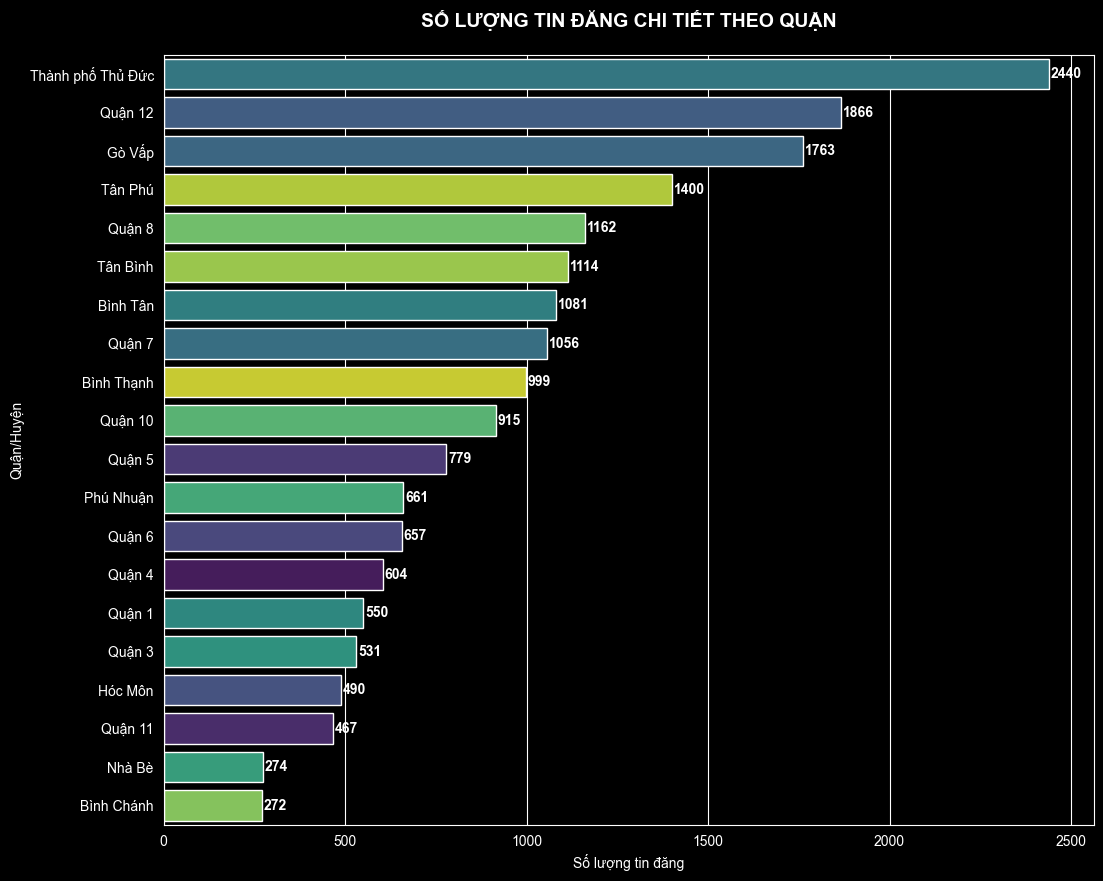

In [21]:
# 1. BIỂU ĐỒ QUẬN
plt.figure(figsize=(12, 10))
dist_order = df['District'].value_counts().index

ax = sns.countplot(
    data=df,
    y='District',
    order=dist_order,
    hue='District', # Thêm hue để gán màu theo quận
    palette='viridis',
    legend=False
)

# Thêm con số cụ thể vào đầu mỗi cột
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{int(width)}',
                (width + 5, p.get_y() + p.get_height()/2),
                va='center', fontsize=10, fontweight='bold')

plt.title('SỐ LƯỢNG TIN ĐĂNG CHI TIẾT THEO QUẬN', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Số lượng tin đăng')
plt.ylabel('Quận/Huyện')
plt.show()

Biểu đồ Phân bổ theo Quận

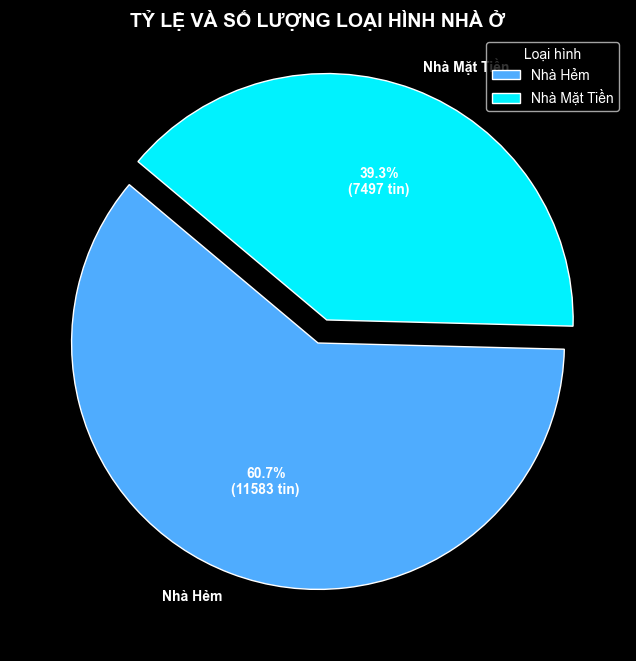

In [22]:
# 2. BIỂU ĐỒ LOẠI HÌNH NHÀ (HẺM VS MẶT TIỀN)
plt.figure(figsize=(8, 8))
hem_counts = df['Is_MatTien'].value_counts()

# Đảm bảo index 0 là Hẻm, 1 là Mặt Tiền theo logic data của mày
labels = ['Nhà Hẻm', 'Nhà Mặt Tiền']
values = [hem_counts.get(0, 0), hem_counts.get(1, 0)]

plt.pie(
    values,
    labels=labels,
    autopct=lambda p: f'{p:.1f}%\n({int(p*sum(values)/100)} tin)', # Hiện cả % và số lượng tin
    startangle=140,
    colors=['#4facfe', '#00f2fe'],
    explode=(0, 0.1), # Làm nổi bật phần nhà mặt tiền
    textprops={'fontweight': 'bold'}
)

plt.legend(labels, title="Loại hình", loc="upper right")
plt.title('TỶ LỆ VÀ SỐ LƯỢNG LOẠI HÌNH NHÀ Ở', fontsize=14, fontweight='bold')
plt.show()

Biểu đồ Loại hình nhà

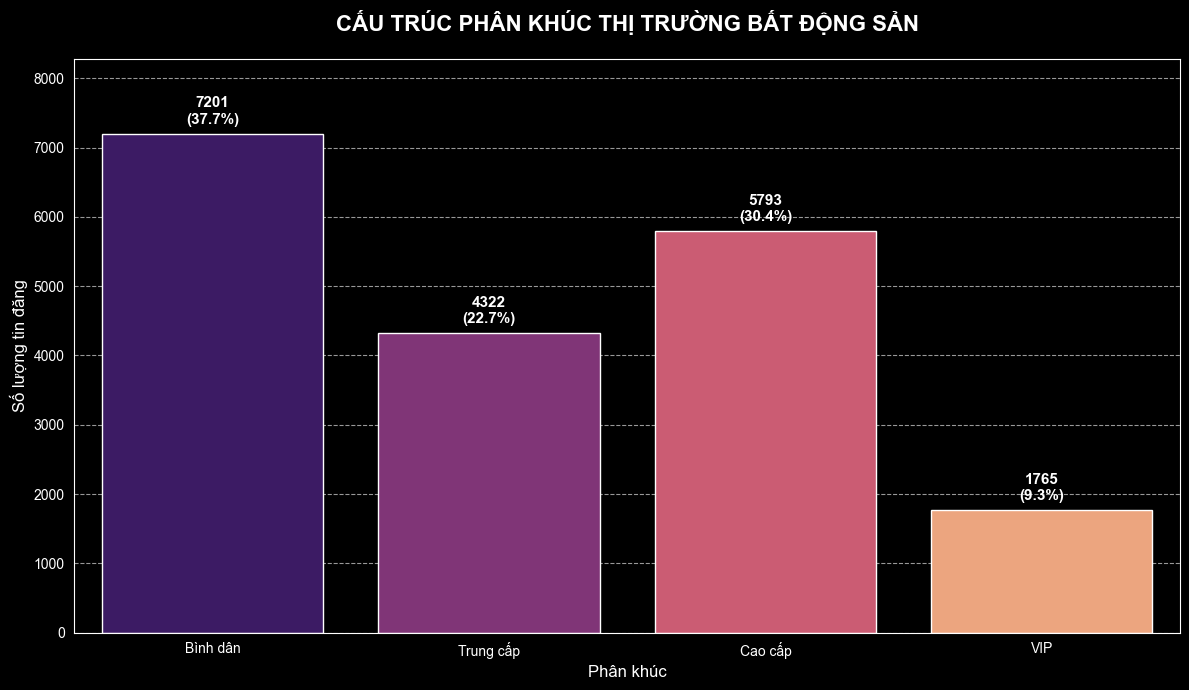

In [23]:
# ---------------------------------------------------------
# CELL: PHÂN TÍCH CẤU TRÚC PHÂN KHÚC (SLIDE 3)
# ---------------------------------------------------------
plt.figure(figsize=(12, 7))

# 1. Chuẩn bị dữ liệu
seg_counts = df['Segment'].value_counts().sort_index()
total = len(df)

# 2. Vẽ biểu đồ
ax = sns.barplot(
    x=seg_counts.index,
    y=seg_counts.values,
    hue=seg_counts.index,
    palette='magma',
    legend=False
)

# 3. Thêm số lượng và tỷ lệ % trên đầu mỗi cột
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(
        f'{int(height)}\n({percentage:.1f}%)', # Hiện cả số lượng và %
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold',
        xytext=(0, 5),
        textcoords='offset points'
    )

# 4. Trang trí chuyên nghiệp
plt.title('CẤU TRÚC PHÂN KHÚC THỊ TRƯỜNG BẤT ĐỘNG SẢN', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Số lượng tin đăng', fontsize=12)
plt.xlabel('Phân khúc', fontsize=12)
plt.ylim(0, max(seg_counts.values) * 1.15) # Tạo khoảng trống phía trên để không bị đè chữ
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Ma trận tương quan (Heatmap)

--- ĐANG PHÂN TÍCH PHÂN PHỐI DỮ LIỆU ---


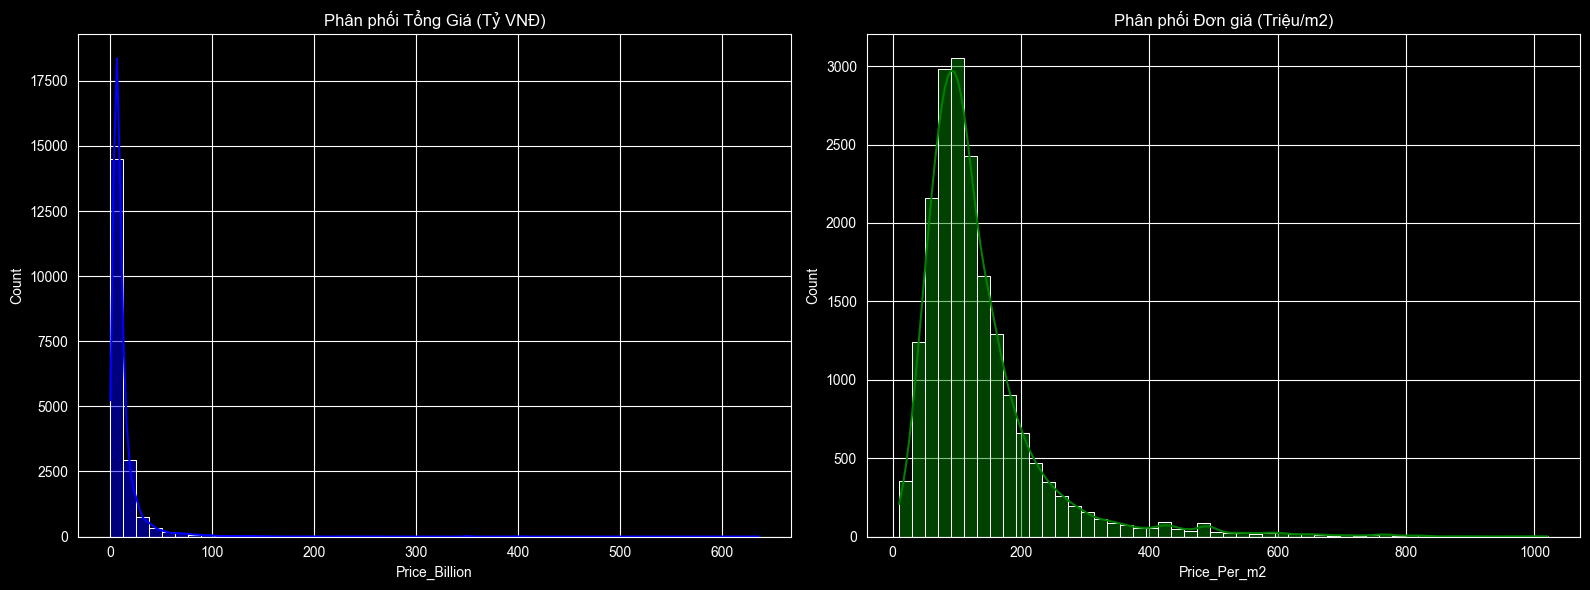

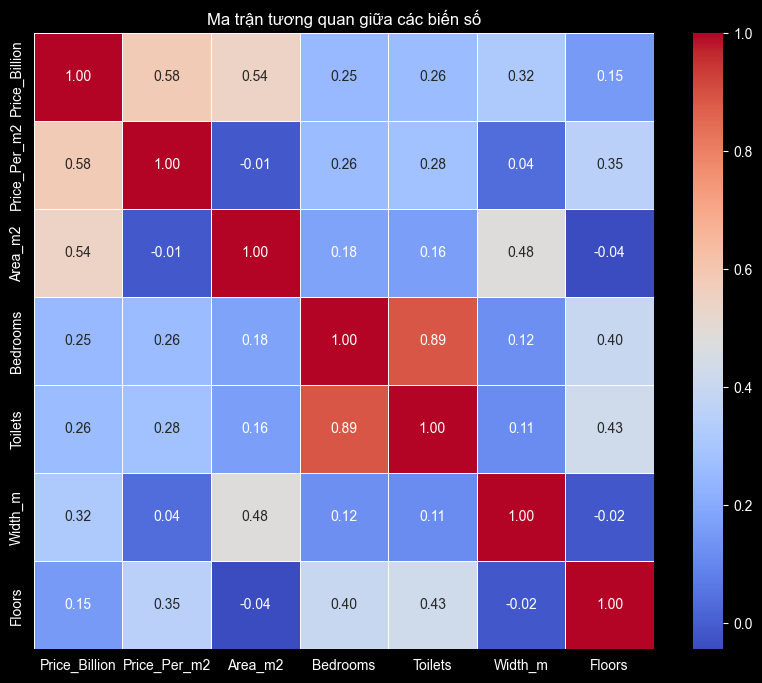

In [24]:
# ==============================================================================
# PHẦN 1: PHÂN PHỐI & MỐI QUAN HỆ CƠ BẢN
# ==============================================================================
print("--- ĐANG PHÂN TÍCH PHÂN PHỐI DỮ LIỆU ---")

# A1. Phân phối Giá & Đơn giá
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df['Price_Billion'], bins=50, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Phân phối Tổng Giá (Tỷ VNĐ)')

sns.histplot(df['Price_Per_m2'], bins=50, kde=True, ax=axes[1], color='green')
axes[1].set_title('Phân phối Đơn giá (Triệu/m2)')
plt.tight_layout()
plt.show()

# B3. Heatmap tương quan (Sử dụng df đang có)
cols_corr = ['Price_Billion', 'Price_Per_m2', 'Area_m2', 'Bedrooms', 'Toilets', 'Width_m', 'Floors']
cols_corr = [c for c in cols_corr if c in df.columns]

plt.figure(figsize=(10, 8))
corr_matrix = df[cols_corr].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Ma trận tương quan giữa các biến số')
plt.show()

Giá trung vị theo từng Quận (Bar Chart)

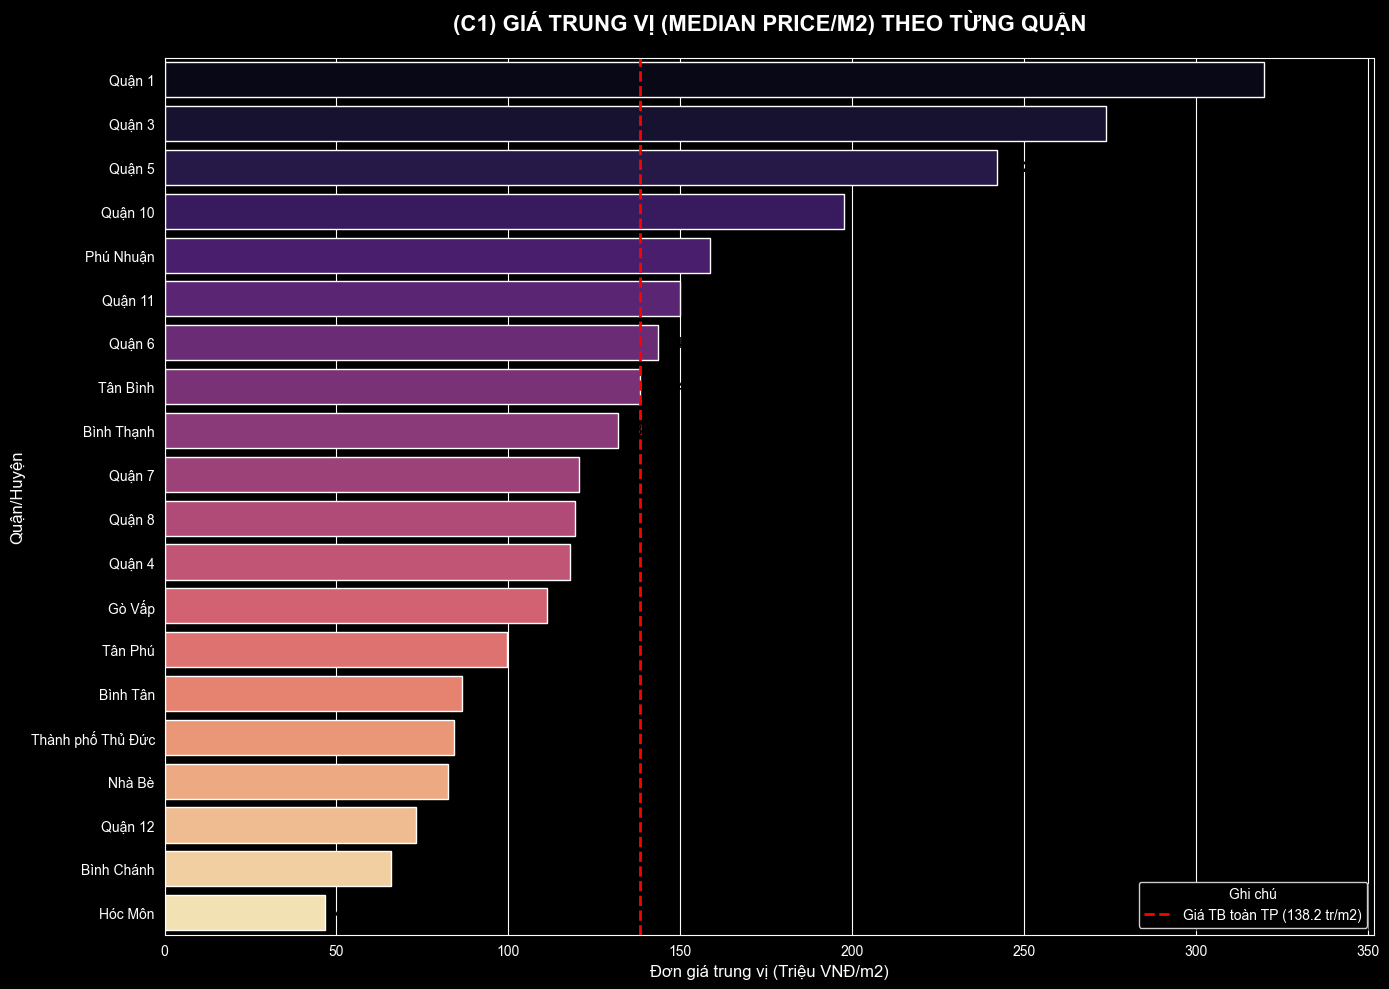

In [25]:
# ---------------------------------------------------------
# CELL: GIÁ TRUNG VỊ THEO TỪNG QUẬN (CÓ SỐ & LEGEND)
# ---------------------------------------------------------
plt.figure(figsize=(14, 10))

# 1. Tính toán Median
median_price = (
    df.groupby('District')['Price_Per_m2']
    .median()
    .sort_values(ascending=False)
    .reset_index()
)

# 2. Tính Mean toàn thành phố để làm mốc so sánh
city_avg = median_price['Price_Per_m2'].mean()

# 3. Vẽ biểu đồ Bar ngang
# Dùng palette 'magma' hoặc 'viridis' để có hiệu ứng màu từ đậm đến nhạt
ax = sns.barplot(
    data=median_price,
    x='Price_Per_m2',
    y='District',
    hue='District', # Gán hue để tạo Legend nếu cần hoặc chỉ để phân màu
    palette='magma',
    legend=False
)

# 4. Thêm đường trung bình toàn TP và ghi chú vào Legend
plt.axvline(
    x=city_avg,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Giá TB toàn TP ({city_avg:.1f} tr/m2)'
)

# 5. HIỂN THỊ SỐ TRÊN ĐẦU CỘT (Cái mày cần)
for p in ax.patches:
    val = p.get_width()
    ax.annotate(
        f'{val:.1f}',
        (val + 3, p.get_y() + p.get_height()/2),
        va='center',
        ha='left',
        fontsize=10,
        fontweight='bold',
        color='black'
    )

# 6. Thiết lập Legend và Tiêu đề
plt.legend(loc='lower right', frameon=True, shadow=True, title="Ghi chú")
plt.title('(C1) GIÁ TRUNG VỊ (MEDIAN PRICE/M2) THEO TỪNG QUẬN', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Đơn giá trung vị (Triệu VNĐ/m2)', fontsize=12)
plt.ylabel('Quận/Huyện', fontsize=12)
plt.xlim(0, median_price['Price_Per_m2'].max() * 1.1) # Tạo khoảng trống để hiện số không bị mất

plt.tight_layout()
plt.show()

PHẦN 2: EDA NGHIỆP VỤ CHUYÊN SÂU

Q1. Phân khúc giá nhà phân bố như thế nào giữa các quận tại TP.HCM?

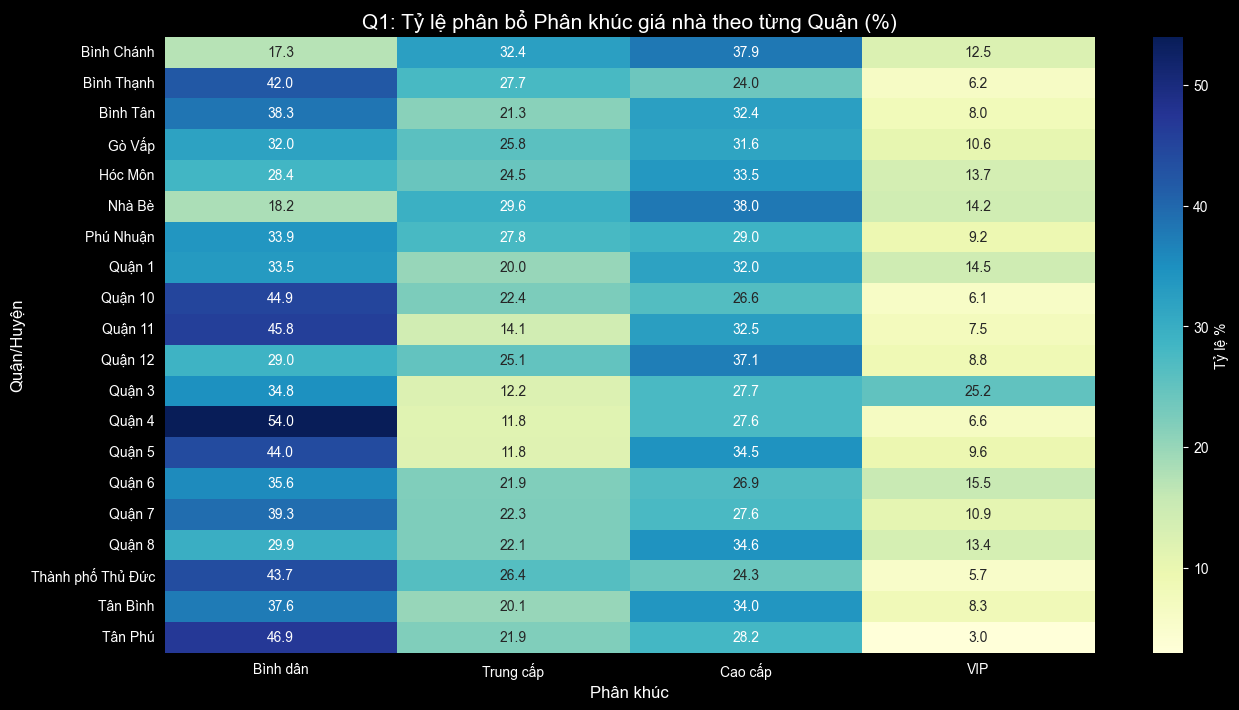

In [26]:
# Visualize Q1: Heatmap District × Segment (theo tỉ lệ phần trăm)
plt.figure(figsize=(15, 8))
ct = pd.crosstab(df['District'], df['Segment'], normalize='index') * 100
sns.heatmap(ct, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Tỷ lệ %'})

plt.title("Q1: Tỷ lệ phân bổ Phân khúc giá nhà theo từng Quận (%)", fontsize=15)
plt.xlabel("Phân khúc", fontsize=12)
plt.ylabel("Quận/Huyện", fontsize=12)
plt.show()

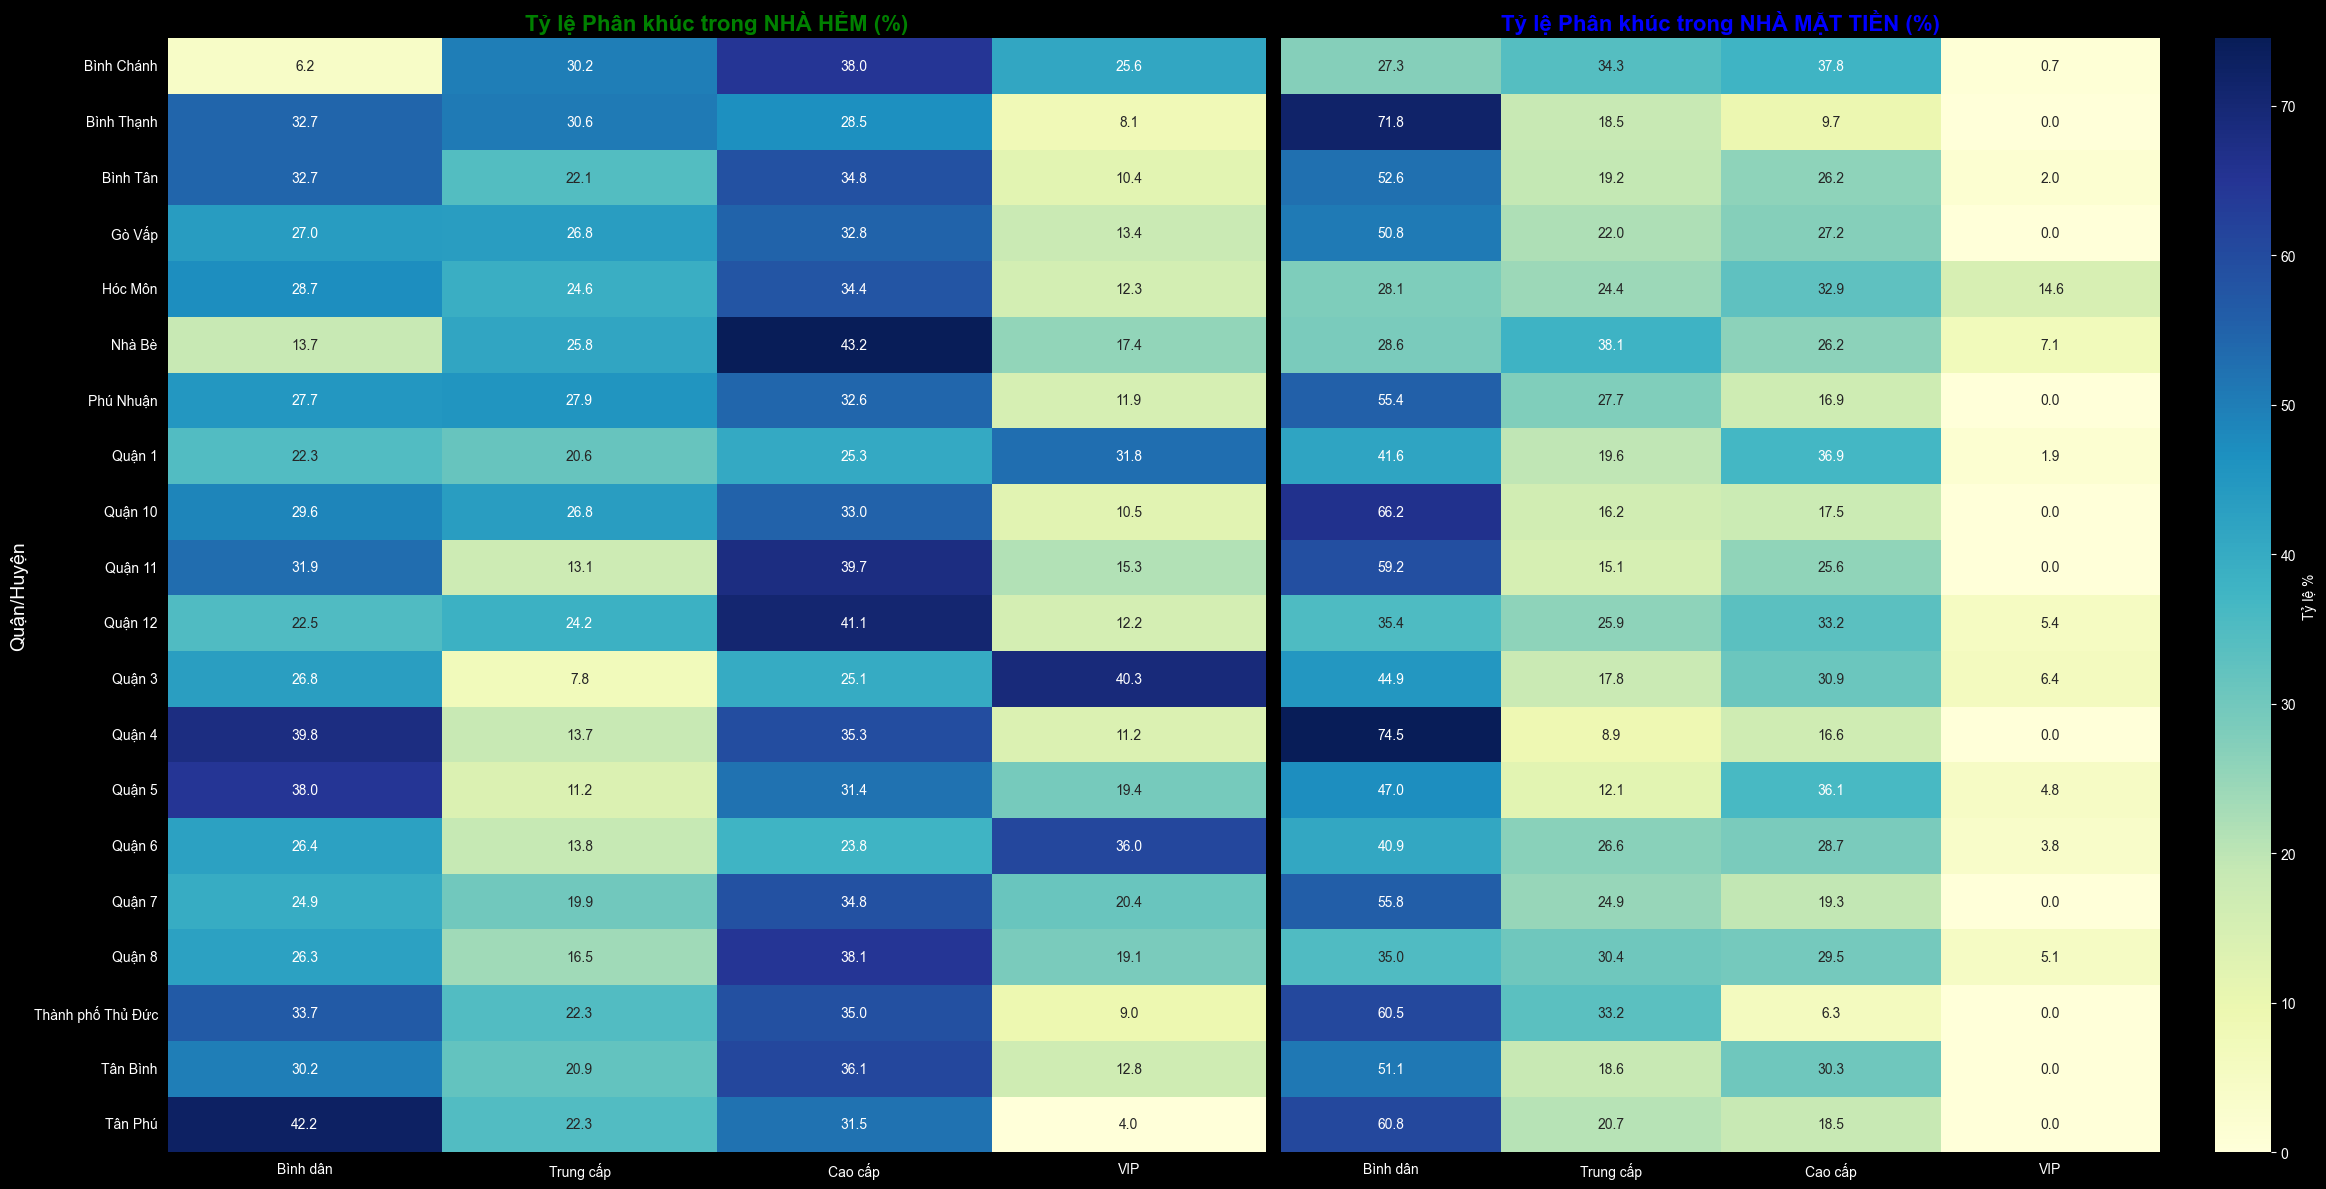

In [27]:
# ---------------------------------------------------------
# 1. CHUẨN BỊ DỮ LIỆU
# ---------------------------------------------------------
# Đảm bảo thứ tự phân khúc đúng chuẩn (để biểu đồ không bị lộn xộn)
thu_tu_phan_khuc = ['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP']
df['Segment'] = pd.Categorical(df['Segment'], categories=thu_tu_phan_khuc, ordered=True)

# ---------------------------------------------------------
# 2. TẠO 2 BẢNG CROSSTAB RIÊNG BIỆT
# ---------------------------------------------------------

# Bảng 1: Dành cho Nhà Hẻm (Is_MatTien == 0)
df_hem = df[df['Is_MatTien'] == 0]
ct_hem = pd.crosstab(df_hem['District'], df_hem['Segment'], normalize='index') * 100

# Bảng 2: Dành cho Nhà Mặt Tiền (Is_MatTien == 1)
df_mattien = df[df['Is_MatTien'] == 1]
ct_mattien = pd.crosstab(df_mattien['District'], df_mattien['Segment'], normalize='index') * 100

# ---------------------------------------------------------
# 3. VẼ BIỂU ĐỒ (2 HÌNH CẠNH NHAU)
# ---------------------------------------------------------
# Tạo khung hình lớn có 1 hàng, 2 cột
fig, axes = plt.subplots(1, 2, figsize=(24, 12), sharey=True) # sharey=True để trục Quận thẳng hàng nhau

# --- VẼ BIỂU ĐỒ 1: NHÀ HẺM ---
sns.heatmap(ct_hem,
            annot=True, fmt=".1f",
            cmap="YlGnBu",
            ax=axes[0],
            cbar=False) # Tắt thanh màu ở hình 1 cho đỡ rối
axes[0].set_title("Tỷ lệ Phân khúc trong NHÀ HẺM (%)", fontsize=16, fontweight='bold', color='green')
axes[0].set_xlabel("")
axes[0].set_ylabel("Quận/Huyện", fontsize=14)

# --- VẼ BIỂU ĐỒ 2: NHÀ MẶT TIỀN ---
sns.heatmap(ct_mattien,
            annot=True, fmt=".1f",
            cmap="YlGnBu",
            ax=axes[1],
            cbar_kws={'label': 'Tỷ lệ %'}) # Chỉ hiện thanh màu ở hình 2
axes[1].set_title("Tỷ lệ Phân khúc trong NHÀ MẶT TIỀN (%)", fontsize=16, fontweight='bold', color='blue')
axes[1].set_xlabel("")
axes[1].set_ylabel("") # Bỏ nhãn trục Y ở hình 2 cho gọn

plt.tight_layout()
plt.show()

Q2. Trong cùng một quận, các phân khúc giá có chồng lấn nhau không?

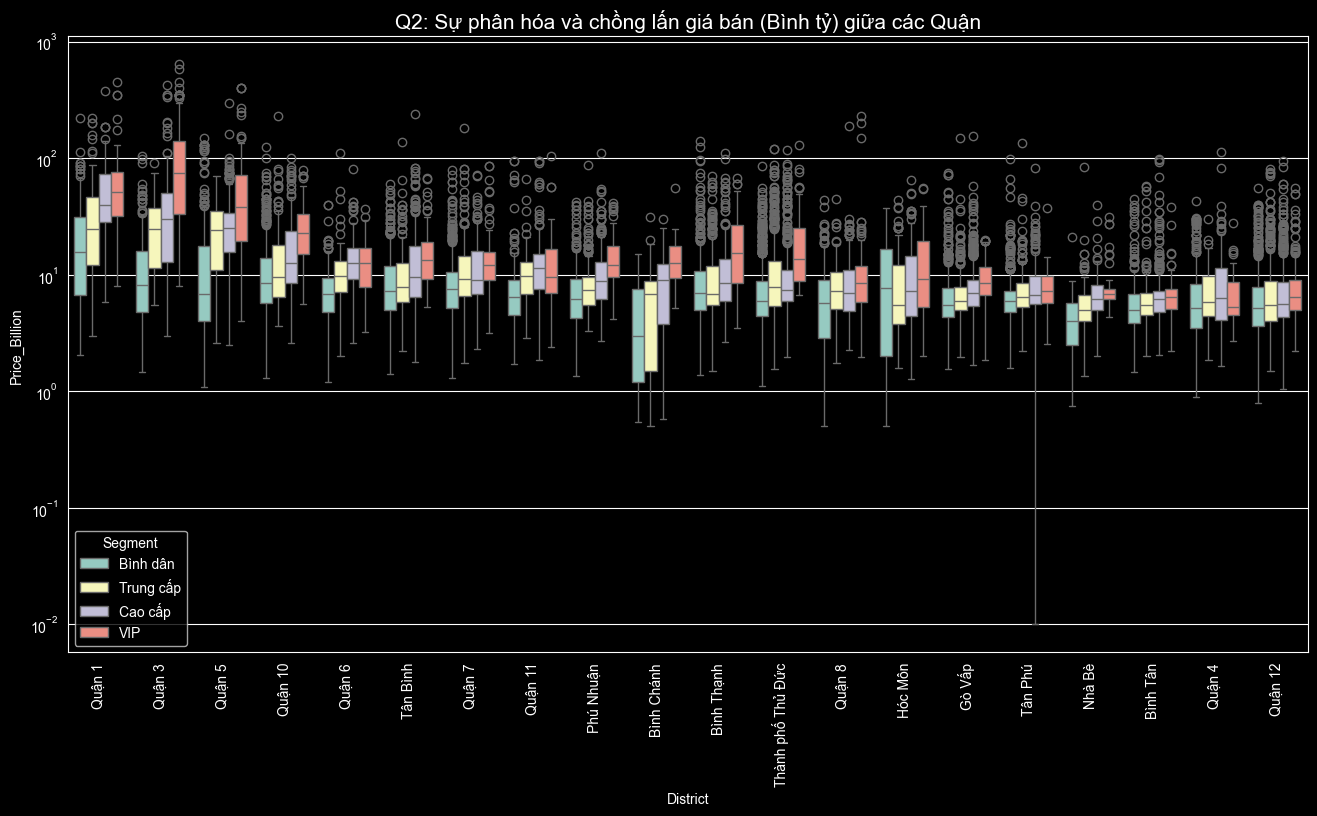

In [28]:
# Visualize Q2: Boxplot Price_Billion theo District (Sắp xếp theo giá trung bình)
plt.figure(figsize=(16, 8))
order = df.groupby('District')['Price_Billion'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='District', y='Price_Billion', order=order, hue="Segment",palette="Set3")

plt.yscale('log') # Dùng thang log để thấy rõ sự chồng lấn ở các phân khúc thấp
plt.xticks(rotation=90)
plt.title("Q2: Sự phân hóa và chồng lấn giá bán (Bình tỷ) giữa các Quận", fontsize=15)
plt.show()

Q4. Giá trên mỗi mét vuông đóng vai trò gì trong việc phân loại?

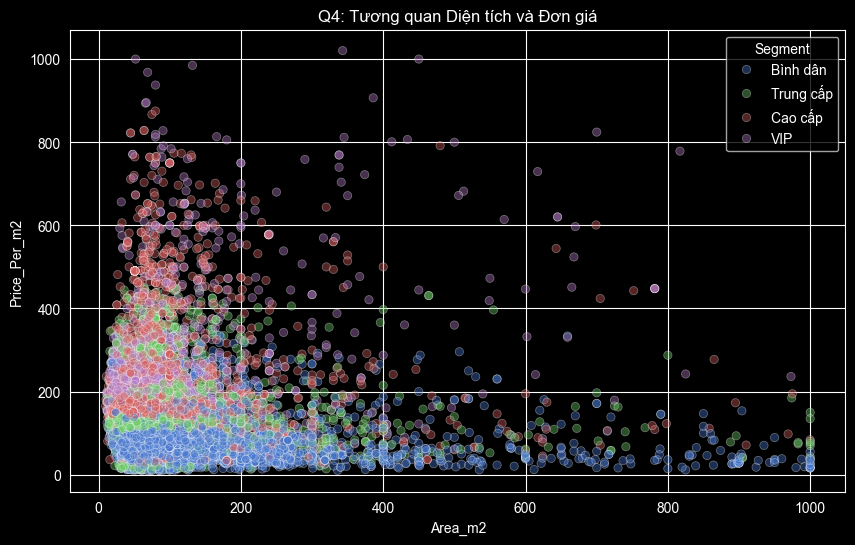

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Area_m2', y='Price_Per_m2', hue='Segment', alpha=0.4)
plt.title("Q4: Tương quan Diện tích và Đơn giá")
plt.show()

Q6. Số tầng ảnh hưởng như thế nào đến phân khúc?

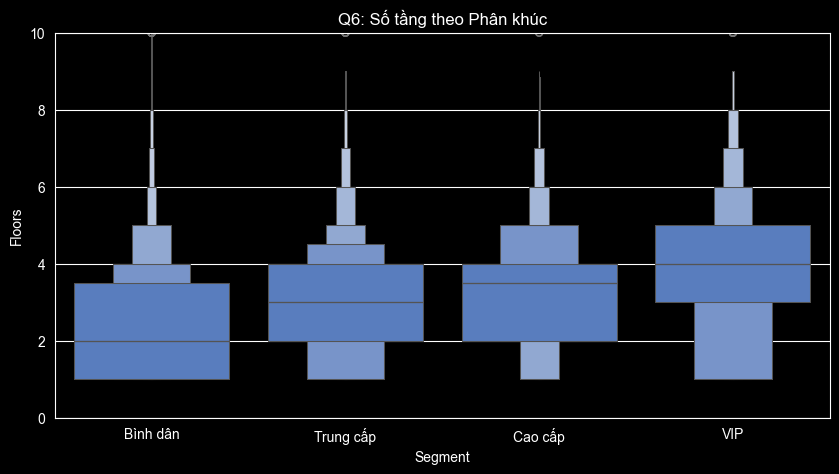

In [30]:
plt.figure(figsize=(10, 5))
sns.boxenplot(data=df, x='Segment', y='Floors')
plt.ylim(0, 10)
plt.title("Q6: Số tầng theo Phân khúc")
plt.show()

Q7. Nhà mặt tiền có xác suất thuộc phân khúc cao hơn không?

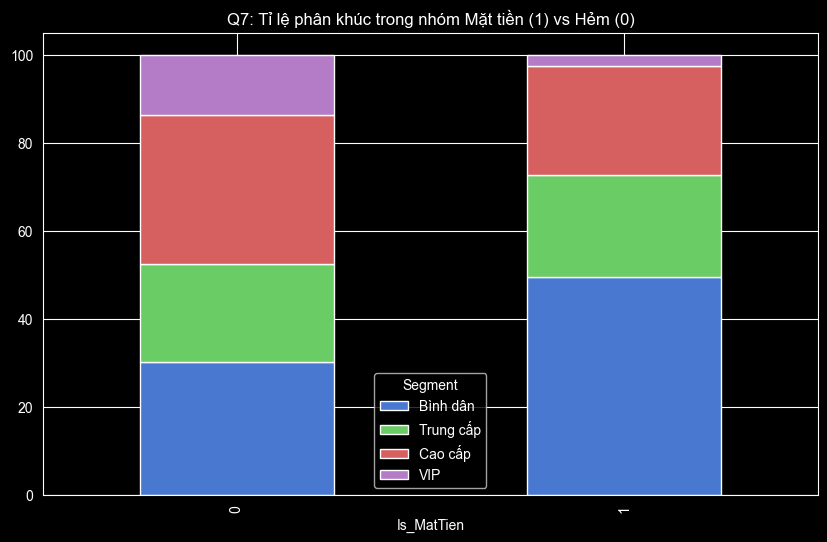

In [31]:
ct = pd.crosstab(df['Is_MatTien'], df['Segment'], normalize='index') * 100
ct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Q7: Tỉ lệ phân khúc trong nhóm Mặt tiền (1) vs Hẻm (0)")
plt.show()

Q8. Nhà trong hẻm thường thuộc phân khúc nào?

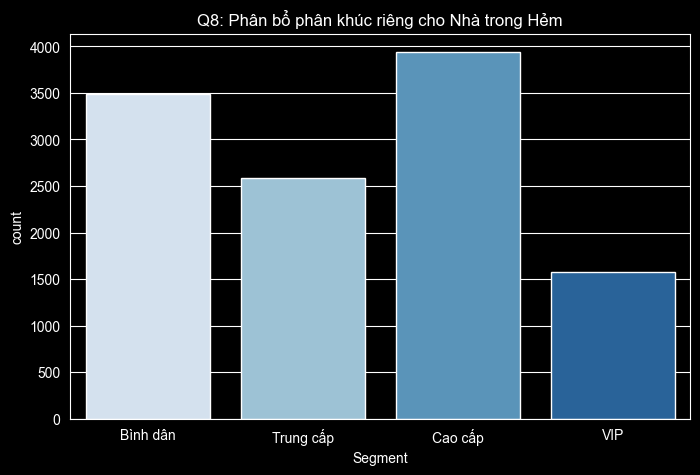

In [32]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df[df['Is Hem'] == 1], x='Segment', palette="Blues",hue="Segment")
plt.title("Q8: Phân bổ phân khúc riêng cho Nhà trong Hẻm")
plt.show()

Q10. Phân khúc nào được đăng bán nhiều nhất theo thời gian?

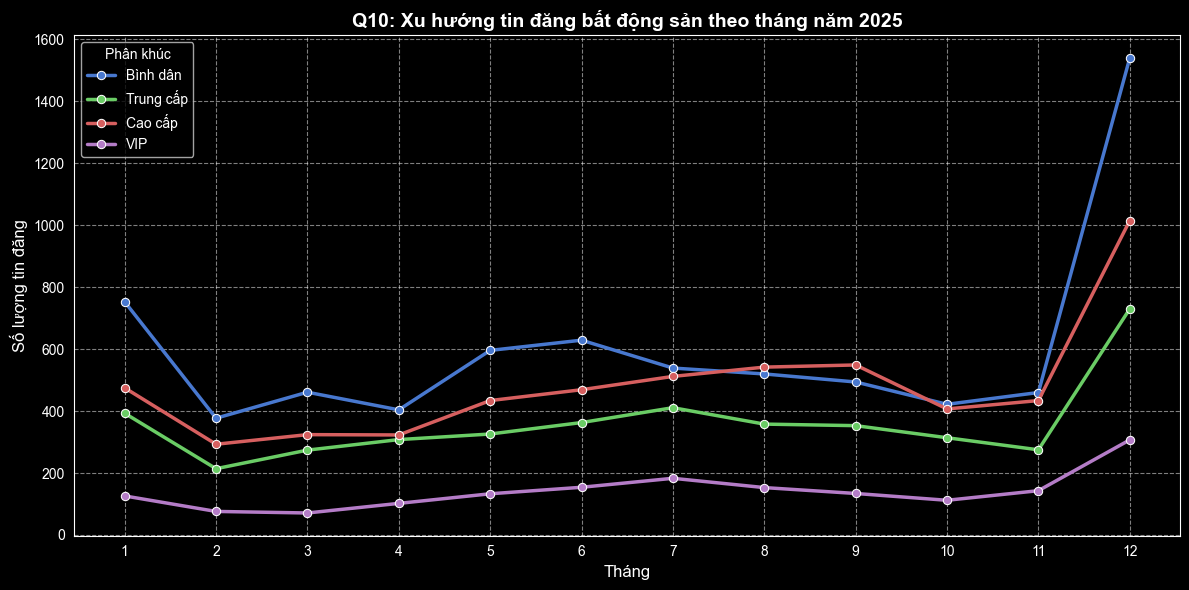

In [33]:
# --- Sửa lỗi Q10 (Xử lý FutureWarning và tối ưu Lineplot) ---

# 1. Đảm bảo Post Time chuẩn (dayfirst=True cực kỳ quan trọng cho data VN)
df['Post Time'] = pd.to_datetime(df['Post Time'], dayfirst=True, errors='coerce')
df['Month'] = df['Post Time'].dt.month

# 2. Groupby với observed=False để tắt cảnh báo FutureWarning
df_trend = df.groupby(['Month', 'Segment'], observed=False).size().reset_index(name='Count')

# 3. Vẽ biểu đồ xu hướng
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_trend,
    x='Month',
    y='Count',
    hue='Segment',
    marker='o',
    linewidth=2.5
)

plt.title("Q10: Xu hướng tin đăng bất động sản theo tháng năm 2025", fontsize=14, fontweight='bold')
plt.xlabel("Tháng", fontsize=12)
plt.ylabel("Số lượng tin đăng", fontsize=12)
plt.xticks(range(1, 13)) # Hiện đủ từ tháng 1 đến tháng 12
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Phân khúc", loc='upper left')
plt.tight_layout()
plt.show()

Q11. Đặc trưng nào quan trọng nhất trong việc phân loại?

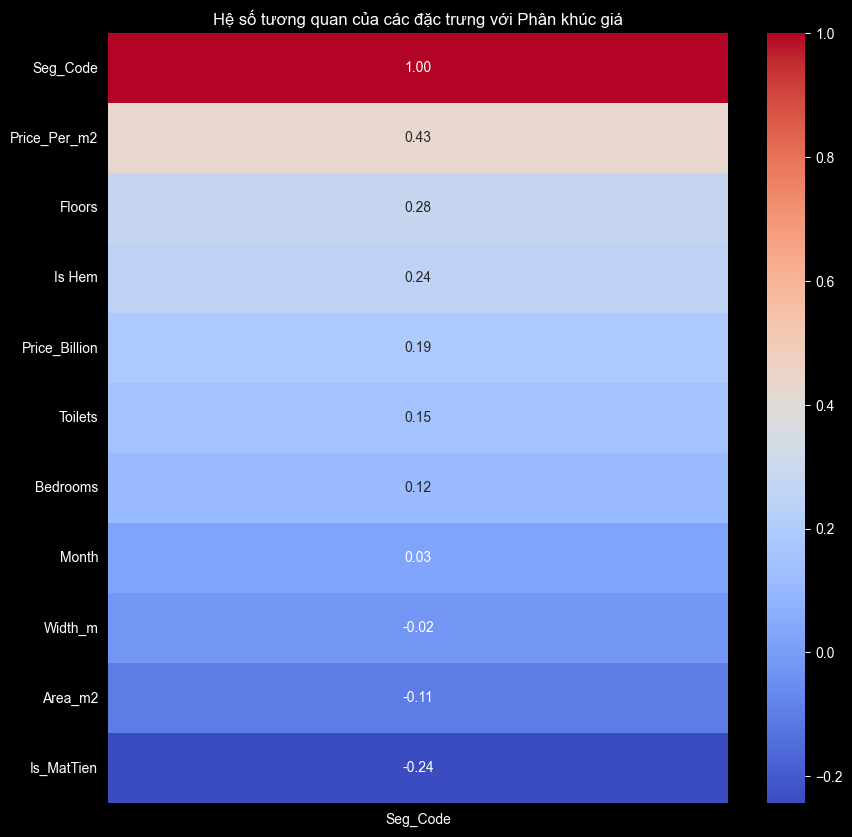

In [34]:
plt.figure(figsize=(10, 10))

# Bước 1: Ép kiểu 'Segment' sang 'category' rồi mới lấy codes
df['Seg_Code'] = df['Segment'].astype('category').cat.codes

# Bước 2: Tính toán tương quan
# Lưu ý: Ta chỉ tính tương quan của các cột số với cột Seg_Code vừa tạo
corr = df.select_dtypes(include=[np.number]).corr()[['Seg_Code']].sort_values(by='Seg_Code', ascending=False)

# Bước 3: Vẽ Heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Hệ số tương quan của các đặc trưng với Phân khúc giá")
plt.show()

Q12. Có thể phân loại mà không dùng Giá bán (Price_Billion) không?
Trả lời: Hoàn toàn có thể. EDA cho thấy các biến cấu trúc (Width_m, Is_MatTien, District) có sự phân hóa rất rõ rệt giữa các nhãn Segment. Đây là tiền đề để xây dựng model Classification ở bước tiếp theo.

Đang vẽ biểu đồ Tổng hợp...


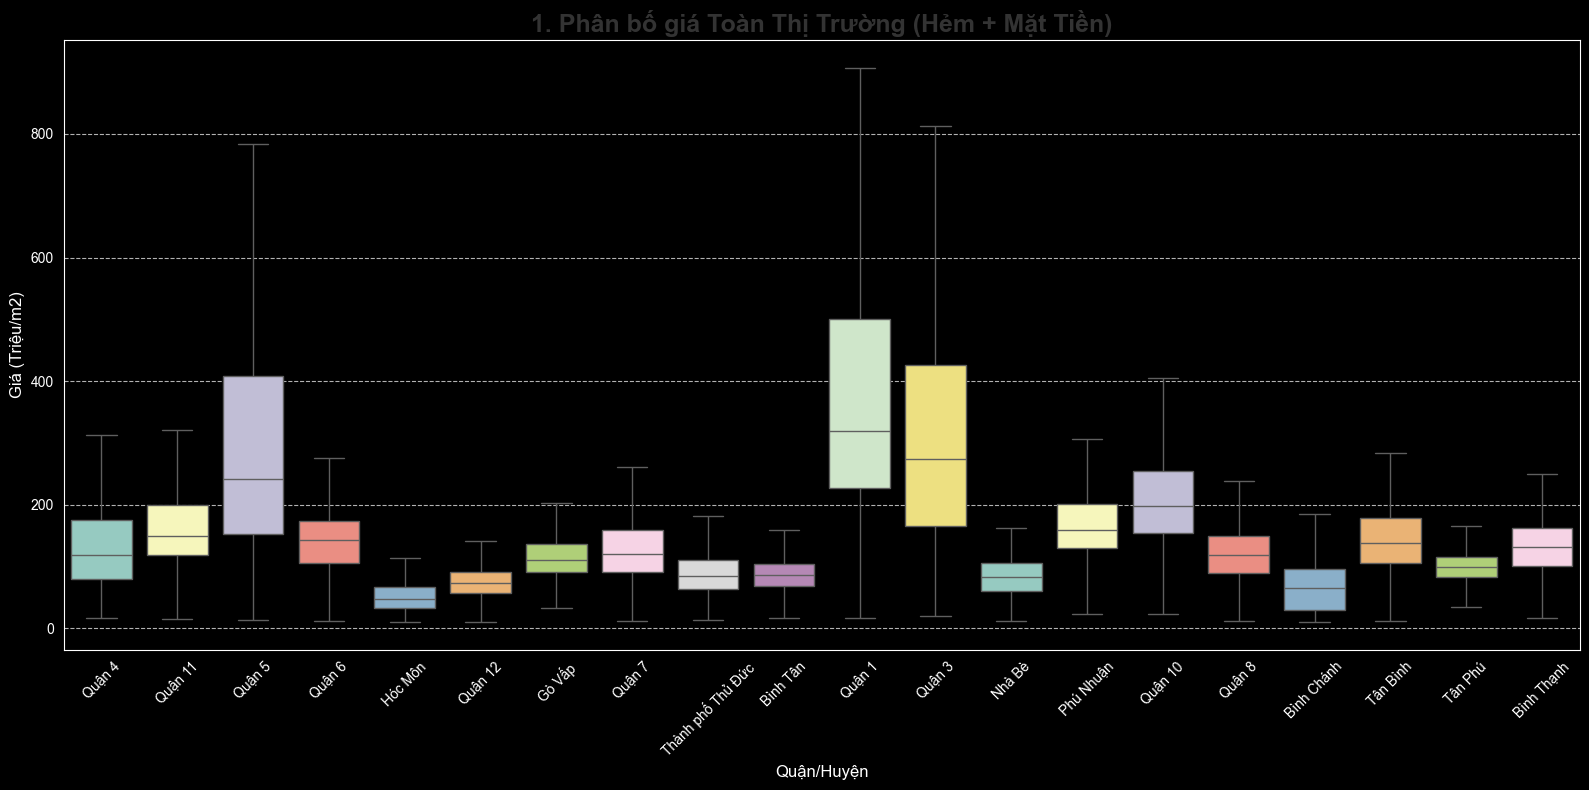

Đang vẽ biểu đồ Mặt tiền...


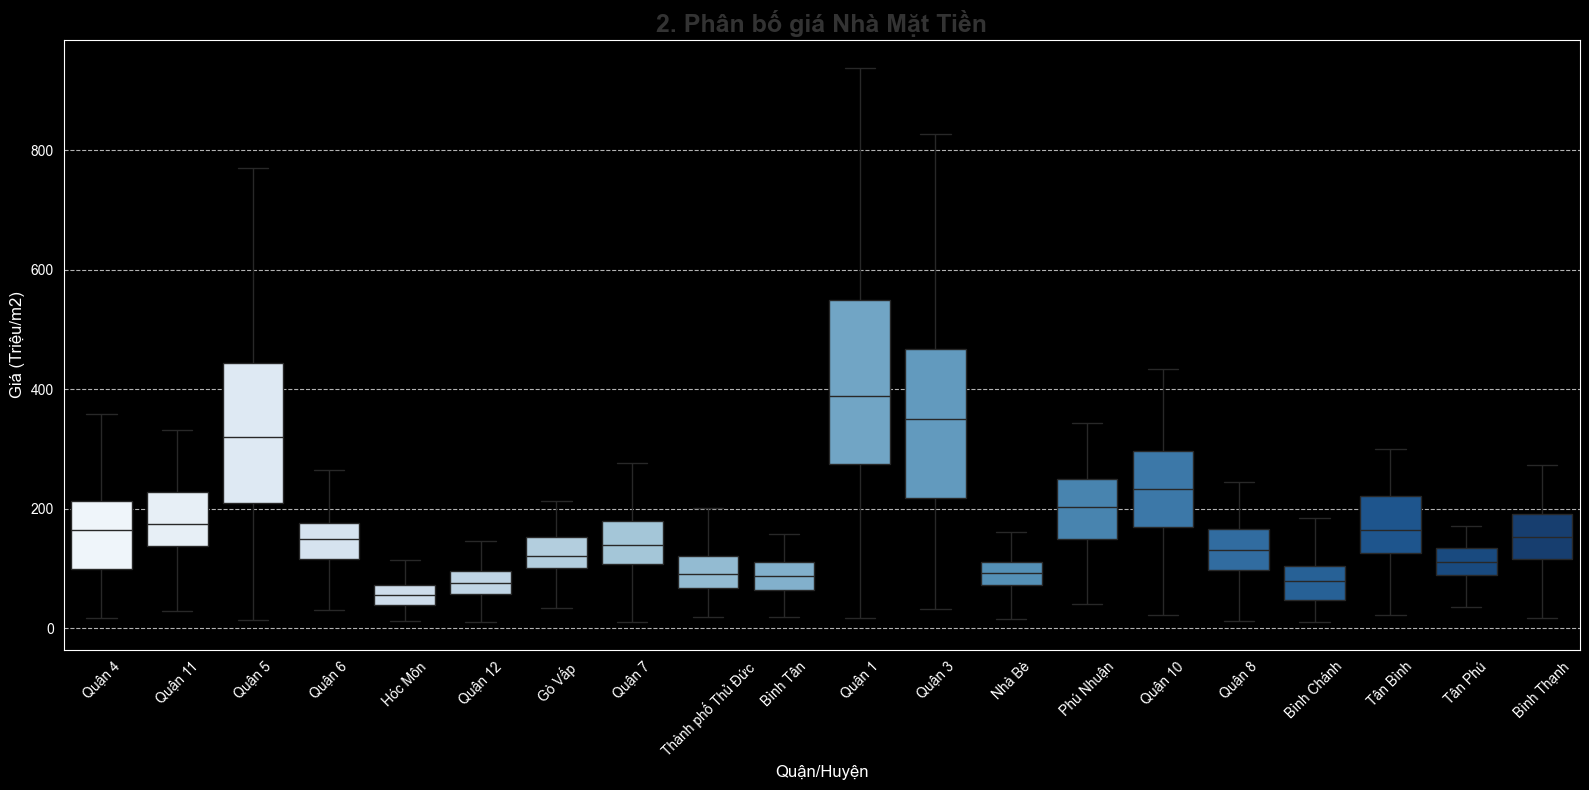

Đang vẽ biểu đồ Nhà hẻm...


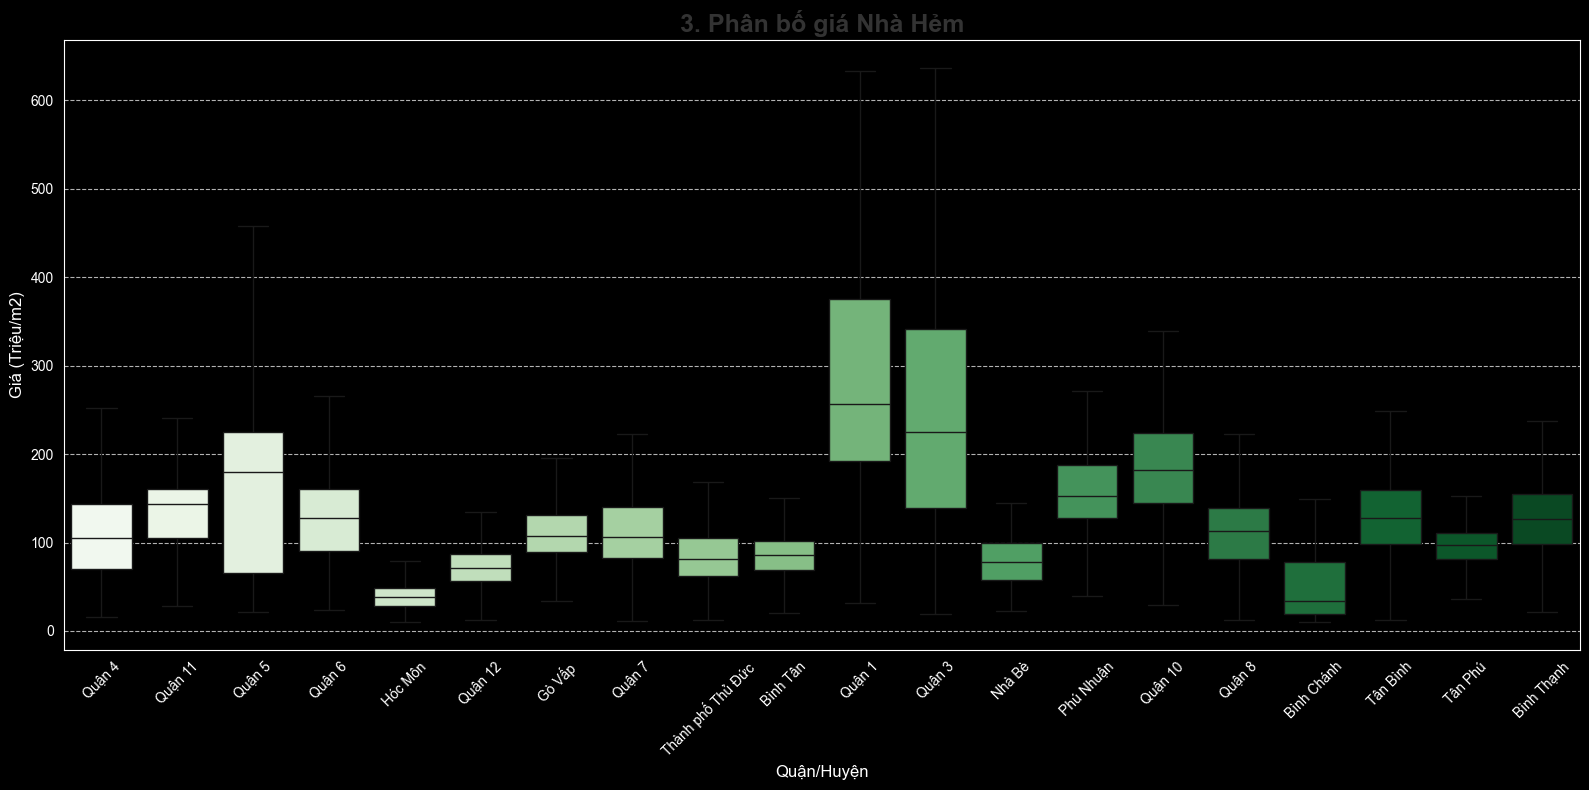

In [35]:
# 2. HÀM VẼ BIỂU ĐỒ (Viết hàm để dùng lại cho gọn)
# ---------------------------------------------------------
def ve_bieu_do_boxplot(data_input, tieu_de, mau_sac):
    # Tạo khung hình lớn (16x8 inch) để hình to, dễ zoom
    plt.figure(figsize=(16, 8))

    # Vẽ Boxplot
    sns.boxplot(
        data=data_input,
        x='District',
        y='Price_Per_m2',
        palette=mau_sac,
        showfliers=False  # Ẩn các điểm ngoại lai (chấm đen) để hộp không bị nén quá nhỏ
    )

    # Trang trí
    plt.title(tieu_de, fontsize=18, fontweight='bold', color='#333333')
    plt.xlabel('Quận/Huyện', fontsize=12)
    plt.ylabel('Giá (Triệu/m2)', fontsize=12)
    plt.xticks(rotation=45) # Xoay tên quận 45 độ cho dễ đọc
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Kẻ dòng mờ cho dễ so sánh
    plt.tight_layout()

    # Hiển thị
    plt.show()

# ---------------------------------------------------------
# 3. THỰC HIỆN VẼ 3 BIỂU ĐỒ
# ---------------------------------------------------------

# === HÌNH 1: TỔNG HỢP (CẢ HẺM VÀ MẶT TIỀN) ===
print("Đang vẽ biểu đồ Tổng hợp...")
ve_bieu_do_boxplot(df,
                   "1. Phân bố giá Toàn Thị Trường (Hẻm + Mặt Tiền)",
                   "Set3")

# === HÌNH 2: CHỈ RIÊNG MẶT TIỀN ===
print("Đang vẽ biểu đồ Mặt tiền...")
df_mattien = df[df['Is_MatTien'] == 1].copy()
ve_bieu_do_boxplot(df_mattien,
                   "2. Phân bố giá Nhà Mặt Tiền",
                   "Blues") # Tông màu xanh dương

# === HÌNH 3: CHỈ RIÊNG NHÀ HẺM ===
print("Đang vẽ biểu đồ Nhà hẻm...")
df_hem = df[df['Is_MatTien'] == 0].copy()
ve_bieu_do_boxplot(df_hem,
                   "3. Phân bố giá Nhà Hẻm",
                   "Greens") # Tông màu xanh lá